Upload vgg16.keras and vgg16_no_ftr.keras (the second model is optional)

# 1. Install dependencies

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [ ]:
# !rm -rf IT1244_data
!git clone https://github.com/ContainerWhale/IT1244_data.git

fatal: destination path 'IT1244_data' already exists and is not an empty directory.


In [ ]:
# Download the second Python file from GitHub
!wget https://raw.githubusercontent.com/ContainerWhale/IT1244_data/main/Code/Symmetry.py

import Symmetry

--2024-04-06 09:09:23--  https://raw.githubusercontent.com/ContainerWhale/IT1244_data/main/Code/Symmetry.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10964 (11K) [text/plain]
Saving to: ‘Symmetry.py.3’

Symmetry.py.3       100%[===================>]  10.71K  --.-KB/s    in 0s      

2024-04-06 09:09:23 (75.4 MB/s) - ‘Symmetry.py.3’ saved [10964/10964]



In [ ]:
from Symmetry import extractLine

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
from sklearn.model_selection import train_test_split

# 2. Read image files

In [ ]:
yes_path = "/content/IT1244_data/Brain Tumor/data/malignant/*.jpg"
no_path = "/content/IT1244_data/Brain Tumor/data/benign/*.jpg"
size = 128
yes, no = [], []
for f in glob.iglob(yes_path):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_to_fit(img, 300)
    img = cv2.resize(img, (size, size))
    yes.append(img)

for f in glob.iglob(no_path):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_to_fit(img, 300)
    img = cv2.resize(img, (size, size))
    no.append(img)


img = np.array(yes + no)
y = np.array([1 if i < len(yes) else 0 for i in range(len(yes)+len(no))])

# 4. Data processing

## 4a. Feature extraction

In [ ]:
temp = extractLine(img)
ftr = np.expand_dims(temp.get_sym(), axis=1)

Uncomment to draw symmetry line on all images

## 4c. Standardisation

In [ ]:
def dataset_standardise_img(dataset):
    '''
    dataset: numpy array of shape (N, ...)
    returns standardised values for each observation, numpy array of shape (N, ...) using dataset standardisation
    '''
    dataset = np.array(dataset)
    mean = np.mean(dataset)
    std = np.std(dataset)

    return (dataset - mean) / std

def standardise_img(dataset):
    '''
    dataset: numpy array of shape (N, ...)
    returns standardised values for each observation, numpy array of shape (N, ...) using per-image standardisation
    '''
    dataset = np.array(dataset)
    l = len(dataset.shape)
    tup = tuple(range(1,l))
    mean = np.mean(dataset, axis=tup, keepdims=True)
    std = np.std(dataset, axis=tup, keepdims=True)

    return (dataset - mean) / std

def standardise_col(dataset):
    '''
    dataset: numpy array of shape (N, D)
    standardises each column
    returns standardised dataset of shape (N, D)
    '''
    dataset = np.array(dataset)
    mean = np.mean(dataset, axis=0)
    std = np.std(dataset, axis=0)
    return (dataset - mean) / std

In [ ]:
img_std = standardise_img(img)
ftr_std = standardise_col(ftr)

# 7. Saliency map

In [ ]:
def generate_saliency_map(model, image_input, ftr_input):
    """Generates a saliency map for a given image, class index, and model."""
    image_tensor = tf.cast(image_input, tf.float32)
    ftr_tensor = tf.cast(ftr_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        pred = model([image_tensor, ftr_tensor], training=False)
        if pred[0] > 0.5:
            loss = pred
        else:
            loss = 1 - pred
        # loss = pred

    grads = tape.gradient(loss, image_tensor)

    # print(grads)
    # process the gradients for visualization
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    return grad_eval, pred[0]

def map_to_img(map):
    rgba_image = plt.cm.jet(map)  # Apply the 'jet' colormap
    rgba_image[:, :, 3] = 0.8  # Set alpha channel to 0.8
    rgb_image = cv2.cvtColor((rgba_image * 255).astype(np.uint8), cv2.COLOR_RGBA2RGB)
    return rgb_image

def visualise(model, index, using_ftr):
    if using_ftr:
        ftr_input = ftr[index:index+1]
    else:
        ftr_input = np.empty((img_std[index:index+1].shape[0], 0))

    map, prob = generate_saliency_map(model, img_std[index:index+1], ftr_input)

    saliency_img = map_to_img(map)
    overlay = cv2.addWeighted(img[index], 0.8, saliency_img, 0.8, 0)

    # display saliency map
    print(f"Prediction: {prob[0]}, Label: {y[index]}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img[index])
    axes[0].set_title('Original Image')
    axes[1].imshow(saliency_img)
    axes[1].set_title('Saliency map')
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay')

    plt.show()

In [ ]:
from keras.models import load_model
vgg16_no_ftr_model = load_model("vgg16_no_ftr.keras")
vgg16_model = load_model("vgg16.keras")

Prediction: 0.8231702446937561, Label: 1


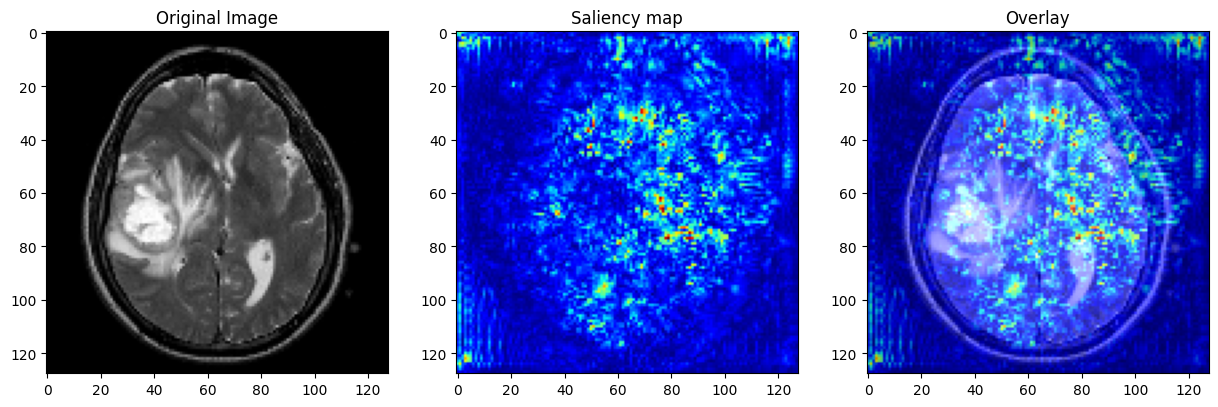

Prediction: 0.2386559247970581, Label: 0


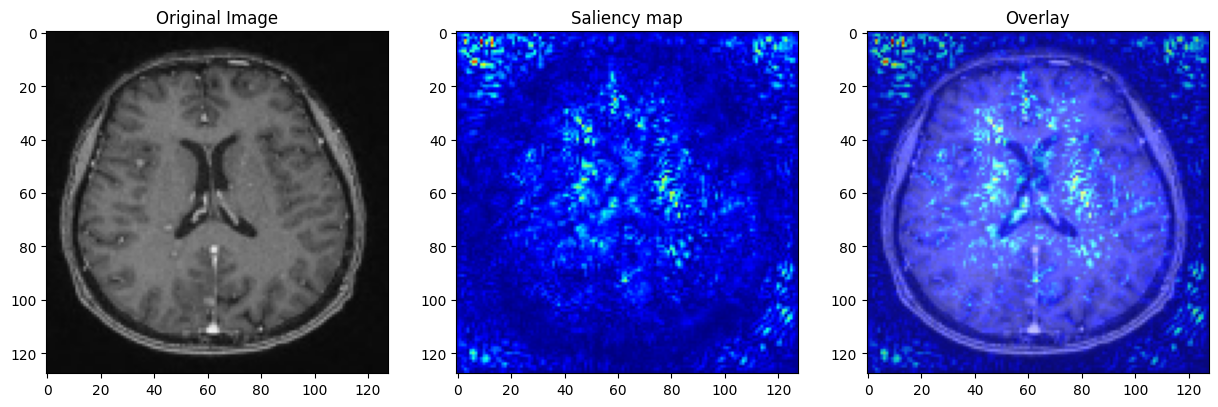

In [ ]:
visualise(vgg16_model, 0, True)
visualise(vgg16_model, 226, True)

# Additional: Comparing saliency maps between VGG16 with symmetry input and VGG16 without symetry input

In [ ]:
pred_ftr = vgg16_model.predict([img_std, ftr])
pred_noftr = vgg16_no_ftr_model.predict([img_std, np.empty((img_std.shape[0], 0))])

8/8 [==============================] - 52s 7s/step


In [ ]:
pred_ftr = pred_ftr.flatten()
pred_noftr = pred_noftr.flatten()

Finding indices for which the two models classify differently

In [ ]:
boole = ((pred_ftr > 0.5) & (pred_noftr <= 0.5)) | ((pred_ftr <= 0.5) & (pred_noftr > 0.5))
indices = np.where(boole)[0]

In [ ]:
for index in indices:
    visualise(vgg16_model, index, True)
    visualise(vgg16_no_ftr_model, index, False)

Output hidden; open in https://colab.research.google.com to view.